In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, featexp, time, datetime

In [18]:
df_raw = pd.read_csv('../data/pluviometrie.csv', delimiter=";")
df_initial = df_raw.copy()
df_initial.sort_values(by=["date"], inplace=True)
df_initial.head()

,uid,date,id,nom,valeur,geo,ville,code_insee
24286,20220415-230000614,2022-04-15T23:00:00+00:00,614,LEZENNES,0.0,"50.61112897101116,3.105120994420723",Ronchin,59507.0
30185,20220415-230000606,2022-04-15T23:00:00+00:00,606,GRIMONPONT,0.0,"50.69231298987998,3.249528645510681",Wattrelos,59650.0
30186,20220415-230000617,2022-04-15T23:00:00+00:00,617,EMMERIN,0.0,"50.58675727008884,3.0076727886082564",Emmerin,59193.0
30187,20220415-230000601,2022-04-15T23:00:00+00:00,601,NEUVILLE,0.0,"50.75581333497077,3.1412037363396936",Neuville-en-Ferrain,59426.0
30188,20220415-230000604,2022-04-15T23:00:00+00:00,604,QUESNOY,0.0,"50.71278844961187,3.0053606482818735",Quesnoy-sur-Deûle,59482.0


# I - Analyse rapide du dataset et compréhension pour de potentiels recalculs
La colonne 'uid' semble clairement être une concaténation de la date et de l'id, on va donc s'en séparer pour le moment.  
Concernant la localisation geographique, on ne gardera que la ville s'il n'y a qu'un pluviomètre par ville dans tous les cas, cela retirera la colonne 'code_insee', 'nom' et 'geo'.  

In [19]:
if 'uid' in df_initial.columns:
    df_initial = df_initial.drop('uid', axis=1)
print(f'Il y a {len(df_initial["nom"].value_counts())} noms, {len(df_initial["id"].value_counts())} ids, {len(df_initial["ville"].value_counts())} villes et {len(df_initial["geo"].value_counts())} repères géographiques.')

Il y a 21 noms, 21 ids, 18 villes et 21 repères géographiques.


Pour simplifier l'utilisation future, on va garder la colonne "nom" et la colonne "geo" afin de pouvoir matcher un nom de ville où un emplacement géographique directement. 

In [20]:
df_initial = df_initial.drop(['code_insee', 'ville', 'id'], axis=1)
df_initial.head()

,date,nom,valeur,geo
24286,2022-04-15T23:00:00+00:00,LEZENNES,0.0,"50.61112897101116,3.105120994420723"
30185,2022-04-15T23:00:00+00:00,GRIMONPONT,0.0,"50.69231298987998,3.249528645510681"
30186,2022-04-15T23:00:00+00:00,EMMERIN,0.0,"50.58675727008884,3.0076727886082564"
30187,2022-04-15T23:00:00+00:00,NEUVILLE,0.0,"50.75581333497077,3.1412037363396936"
30188,2022-04-15T23:00:00+00:00,QUESNOY,0.0,"50.71278844961187,3.0053606482818735"


In [21]:
def conv():
    return lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+00:00").timetuple()) if '+00' in x else time.mktime(datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+01:00").timetuple())
df_initial["date"] = df_initial["date"].apply(conv())
df_initial.head()

,date,nom,valeur,geo
24286,1.650056e+09,LEZENNES,0.0,"50.61112897101116,3.105120994420723"
30185,1.650056e+09,GRIMONPONT,0.0,"50.69231298987998,3.249528645510681"
30186,1.650056e+09,EMMERIN,0.0,"50.58675727008884,3.0076727886082564"
30187,1.650056e+09,NEUVILLE,0.0,"50.75581333497077,3.1412037363396936"
30188,1.650056e+09,QUESNOY,0.0,"50.71278844961187,3.0053606482818735"


In [29]:
df_lille = df_initial[df_initial.nom == "LILLE"]
df_lille.sort_values(by=["date"], inplace=True)
df_lille.head()

/tmp/ipykernel_4757/3790146070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille.sort_values(by=["date"], inplace=True)


,date,nom,valeur,geo
32227,1.650056e+09,LILLE,0.0,"50.647267167546616,3.0646899495752478"
80544,1.650060e+09,LILLE,0.0,"50.647267167546616,3.0646899495752478"
30191,1.650064e+09,LILLE,0.0,"50.647267167546616,3.0646899495752478"
24295,1.650067e+09,LILLE,0.0,"50.647267167546616,3.0646899495752478"
30200,1.650071e+09,LILLE,0.0,"50.647267167546616,3.0646899495752478"


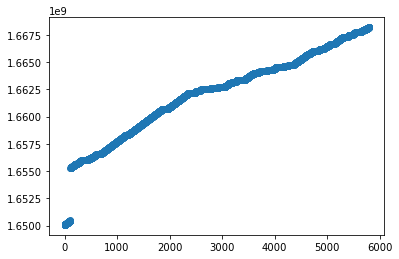

In [32]:
plt.scatter([x for x in range(df_lille.date.shape[0])],df_lille.date)

In [36]:
timestamps = df_lille["date"].to_numpy()
ecarts_timestamps = (timestamps[:-1] - timestamps[1:])
timestamps = timestamps[:-1]
timestamps = timestamps[ecarts_timestamps < 0]
ecarts_timestamps = ecarts_timestamps[ecarts_timestamps < 0]

print(ecarts_timestamps.shape, timestamps.shape)

ecart_moyen = np.mean(ecarts_timestamps)
print(f"L'écart moyen entre 2 enregistrements est en moyenne de {-1*ecart_moyen:.2f}s")

(5798,) (5798,)
L'écart moyen entre 2 enregistrements est en moyenne de 3130.60s


In [37]:
pas_de_temps_max = 3600

(7352,)


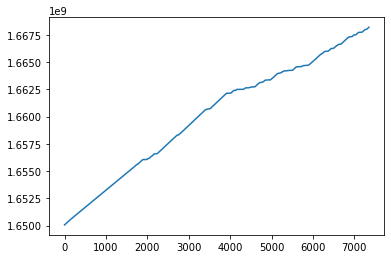

In [38]:
nb_timestamps_initial = timestamps.shape[0]
timestamps_smoothed = []
offset = 0
for timestamp in range(nb_timestamps_initial - 1):
    timestamps_smoothed.append(timestamps[timestamp])
    ecart_timestamps = ecarts_timestamps[timestamp]
    nb_rajout = 1
    while timestamps_smoothed[-1] - timestamps[timestamp + 1] < (-1)*3600:
        offset += 1
        timestamps_smoothed.append(timestamps[timestamp] - nb_rajout*np.floor(ecart_moyen))
        nb_rajout += 1
timestamps_smoothed = np.array(timestamps_smoothed)
ecarts_timestamps_smoothed = (timestamps_smoothed[:-1] - timestamps_smoothed[1:])
print(ecarts_timestamps_smoothed.shape)
plt.plot(timestamps_smoothed)

In [41]:
timestamps = timestamps_smoothed
ecarts_timestamps = (timestamps[:-1] - timestamps[1:])
timestamps = timestamps[:-1]
timestamps = timestamps[ecarts_timestamps < 0]
ecarts_timestamps = ecarts_timestamps[ecarts_timestamps < 0]

print(ecarts_timestamps.shape, timestamps.shape)

ecart_moyen = np.mean(ecarts_timestamps)
print(f"L'écart moyen entre 2 enregistrements est en moyenne de {-1*ecart_moyen:.2f}s")

(7352,) (7352,)
L'écart moyen entre 2 enregistrements est en moyenne de 2467.90s


array([], dtype=float64)

In [72]:
values = []
for timestamp in range(len(timestamps)):
    if df_lille[df_lille.date == timestamps[timestamp]].shape[0] == 1:
        values.append(df_lille[df_lille.date == timestamps[timestamp]].valeur.item())
    else:
        intervalle = timestamps[timestamp+1] - timestamps[timestamp-1]
        #recuperation valeur instant précéddent
        if df_lille[df_lille.date == timestamps[timestamp-1]].shape[0] == 1:
            value_avant = df_lille[df_lille.date == timestamps[timestamp - 1]].valeur.item()
        else:
            value_avant = values[-1]
        ponderation_avant = 1 - ((timestamps[timestamp] - timestamps[timestamp - 1])/intervalle)
        
        #récupération valeur instant suivant
        if df_lille[df_lille.date == timestamps[timestamp+1]].shape[0] == 1:
            value_apres = df_lille[df_lille.date == timestamps[timestamp + 1]].valeur.item()
        else:
            value_apres = values[-1]

        ponderation_apres = 1 - ((timestamps[timestamp+1] - timestamps[timestamp])/intervalle)
        
        value_ponderee = ponderation_avant * value_avant + ponderation_apres * value_apres
        values.append(value_ponderee)

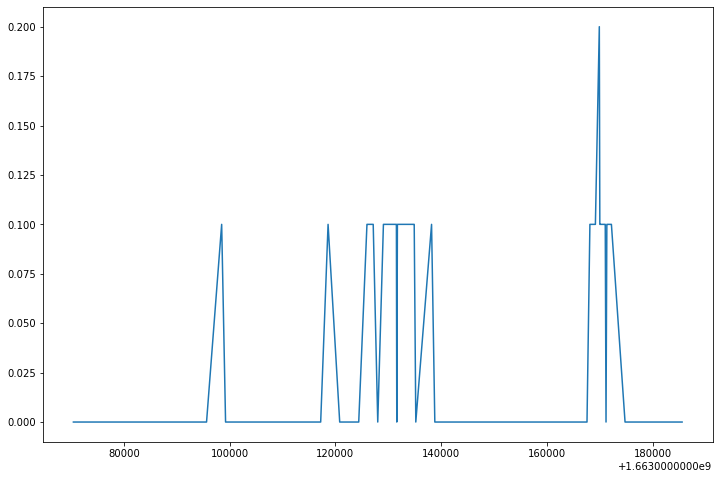

In [76]:
plt.figure(figsize=(12,8))
plt.plot(timestamps[4700:4800], values[4700:4800])

In [85]:
timestamps_train = np.array(timestamps[:4500]).reshape(-1,1)
timestamps_test = np.array(timestamps[4500:]).reshape(-1,1)
values_train = np.array(values[:4500]).reshape(-1,1)
values_test = np.array(values[4500:]).reshape(-1,1)

/home/fragdata/.local/lib/python3.10/site-packages/xgboost/core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


2.03


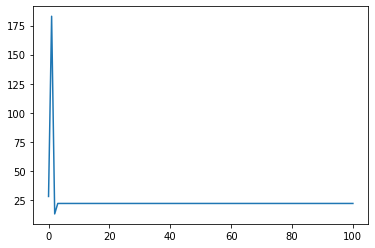

In [101]:
import xgboost as xgb
scores = []
for eta in np.linspace(0.01, 100, 100):
    param = {'eta': eta, 'objective': 'reg:squaredlogerror', 'predictor': 'gpu_predictor'}
    param['nthread'] = 16
    param['eval_metric'] = 'mae'
    num_round = 10
    preds = []
    dtrain = xgb.DMatrix(timestamps_train, label=values_train)
    dtest = xgb.DMatrix(timestamps_test, label=values_test)
    evallist = [(dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
    scores.append(bst.get_score()['f0'])
    
plt.plot(np.linspace(0.01, 100, 100), scores)
print(np.linspace(0.01, 100, 100)[np.argmin(scores)])

/home/fragdata/.local/lib/python3.10/site-packages/xgboost/core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


2.0606060606060606


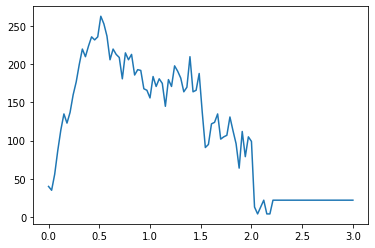

In [102]:
import xgboost as xgb
scores = []
intervalle = np.linspace(0, 3, 100)
for eta in intervalle:
    param = {'eta': eta, 'objective': 'reg:squaredlogerror', 'predictor': 'gpu_predictor'}
    param['nthread'] = 16
    param['eval_metric'] = 'mae'
    num_round = 10
    preds = []
    dtrain = xgb.DMatrix(timestamps_train, label=values_train)
    dtest = xgb.DMatrix(timestamps_test, label=values_test)
    evallist = [(dtrain, 'train')]
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
    scores.append(bst.get_score()['f0'])
    
plt.plot(intervalle, scores)
print(intervalle[np.argmin(scores)])

In [103]:
import xgboost as xgb
param = {'eta': 2.06, 'objective': 'reg:squaredlogerror', 'predictor': 'gpu_predictor'}
param['nthread'] = 16
param['eval_metric'] = 'mae'
num_round = 10
preds = []
dtrain = xgb.DMatrix(timestamps_train, label=values_train)
dtest = xgb.DMatrix(timestamps_test, label=values_test)
evallist = [(dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
ypred = bst.predict(dtest)

/home/fragdata/.local/lib/python3.10/site-packages/xgboost/core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


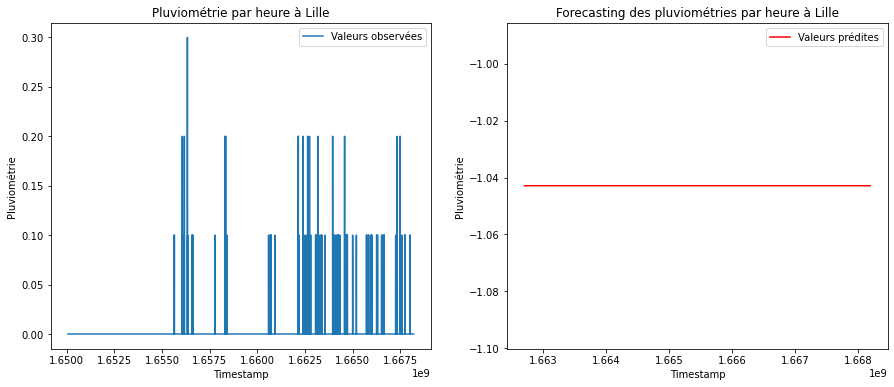

In [104]:
plt.figure(figsize=(15,6))
_ = plt.subplot(1,2,1)
_ = plt.plot(timestamps,values, label='Valeurs observées')
_ = plt.title("Pluviométrie par heure à Lille")
_ = plt.ylabel("Pluviométrie")
_ = plt.xlabel("Timestamp")
_ = plt.legend()
_ = plt.subplot(1,2,2)
_ = plt.plot(timestamps_test, ypred, c='r', label='Valeurs prédites')
_ = plt.title("Forecasting des pluviométries par heure à Lille")
_ = plt.ylabel("Pluviométrie")
_ = plt.xlabel("Timestamp")
_ = plt.legend()

In [115]:
df_lille.index = pd.to_datetime(df_lille['date'])

<Figure size 1080x576 with 0 Axes>

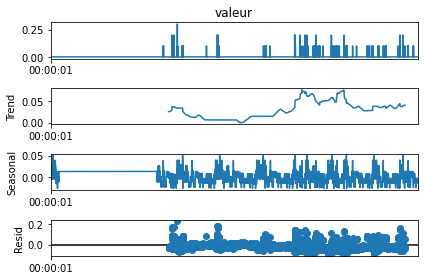

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
plt.figure(figsize=(15,8))
decompose_data = seasonal_decompose(df_lille.valeur, period=600, model="additive")
decompose_data.plot()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37767D+00    |proj g|=  2.68523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     18      1     0     0   2.685D-03  -1.378D+00
  F =  -1.3776667145735715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


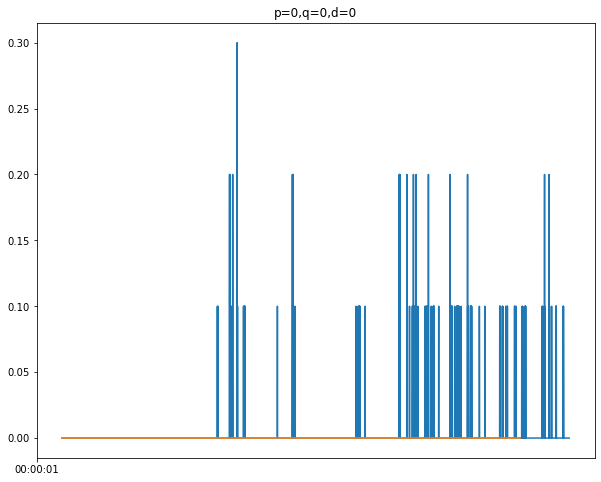

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67107D+00    |proj g|=  9.18137D+00

At iterate    5    f= -1.79673D+00    |proj g|=  1.21779D+00

At iterate   10    f= -1.82682D+00    |proj g|=  1.05849D+00

At iterate   15    f= -1.82724D+00    |proj g|=  1.22074D-02

At iterate   20    f= -1.82729D+00    |proj g|=  7.13102D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     40      1     0     0   2.657D-03  -1.827D+00
  F =  -

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


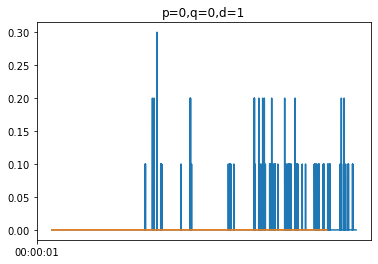

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74523D+00    |proj g|=  1.13656D+01

At iterate    5    f= -1.96665D+00    |proj g|=  1.86989D-01

At iterate   10    f= -1.98017D+00    |proj g|=  6.74416D-01

At iterate   15    f= -1.98157D+00    |proj g|=  2.47493D-02

At iterate   20    f= -1.98200D+00    |proj g|=  5.48878D-03

At iterate   25    f= -1.98203D+00    |proj g|=  2.95491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5    

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


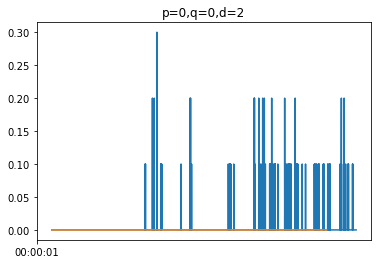

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77587D+00    |proj g|=  1.21443D+01

At iterate    5    f= -2.03985D+00    |proj g|=  3.04517D-01

At iterate   10    f= -2.04500D+00    |proj g|=  3.22514D+00

At iterate   15    f= -2.05858D+00    |proj g|=  6.02428D-02

At iterate   20    f= -2.05992D+00    |proj g|=  7.25814D-03

At iterate   25    f= -2.05995D+00    |proj g|=  1.63259D-02

At iterate   30    f= -2.05996D+00    |proj g|=  6.00905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N 

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


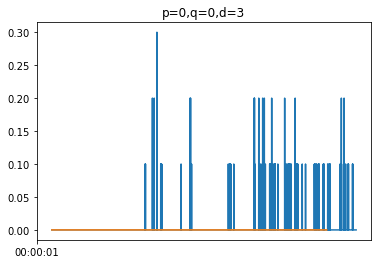

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79524D+00    |proj g|=  1.25592D+01

At iterate    5    f= -2.07835D+00    |proj g|=  9.72472D-02

At iterate   10    f= -2.08160D+00    |proj g|=  2.76279D+00

At iterate   15    f= -2.08803D+00    |proj g|=  2.85140D-01

At iterate   20    f= -2.09127D+00    |proj g|=  2.01529D-01

At iterate   25    f= -2.09175D+00    |proj g|=  2.76796D-02

At iterate   30    f= -2.09176D+00    |proj g|=  3.82230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N 

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


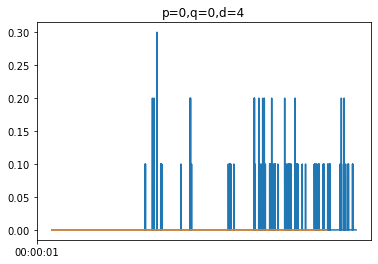

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76852D+00    |proj g|=  4.82553D-02

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      4     61      2     0     0   8.207D-03  -1.769D+00
  F =  -1.7685165052524234     

ABNORMAL_TERMINATION_IN_LNSRCH                              

 Line search cannot locate an adequate point after 20 function
  and g

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


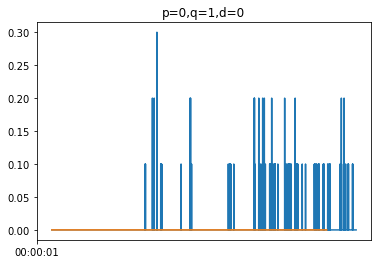

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10669D+00    |proj g|=  1.16653D+01

At iterate    5    f= -2.16996D+00    |proj g|=  4.07078D-01

At iterate   10    f= -2.17900D+00    |proj g|=  6.26656D+00

At iterate   15    f= -2.20865D+00    |proj g|=  6.91257D-02

At iterate   20    f= -2.21114D+00    |proj g|=  8.56102D-02

At iterate   25    f= -2.23405D+00    |proj g|=  4.23880D-01

At iterate   30    f= -2.23632D+00    |proj g|=  1.64766D-01

At iterate   35    f= -2.23636D+00    |proj g|=  6.21073D-03

At iterate   40    f= -2.23636D+00    |proj g|=  2.72011D-02

At iterate   45    f= -2.23636D+00    |proj g|=  4.46181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


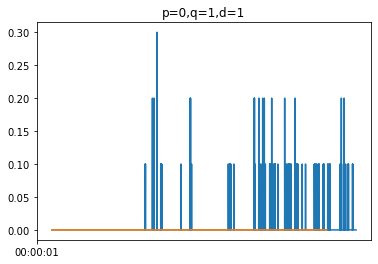

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12769D+00    |proj g|=  1.26691D+01

At iterate    5    f= -2.20460D+00    |proj g|=  7.02106D-01

At iterate   10    f= -2.20763D+00    |proj g|=  6.80761D-02

At iterate   15    f= -2.20781D+00    |proj g|=  6.91067D-01

At iterate   20    f= -2.21507D+00    |proj g|=  2.13169D+00

At iterate   25    f= -2.21664D+00    |proj g|=  1.72879D-01

At iterate   30    f= -2.21896D+00    |proj g|=  2.54412D+00

At iterate   35    f= -2.22665D+00    |proj g|=  1.82250D-01

At iterate   40    f= -2.22746D+00    |proj g|=  6.43560D-01

At iterate   45    f= -2.23558D+00    |proj g|=  6.14796D-01


/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.23645D+00    |proj g|=  5.29592D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   5.296D-02  -2.236D+00
  F =  -2.2364548193071734     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


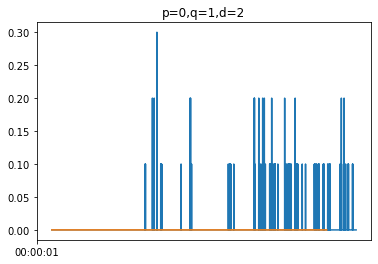

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13587D+00    |proj g|=  1.31435D+01

At iterate    5    f= -2.21994D+00    |proj g|=  3.39286D-01

At iterate   10    f= -2.22307D+00    |proj g|=  2.58631D+00

At iterate   15    f= -2.22484D+00    |proj g|=  6.48399D-01

At iterate   20    f= -2.22538D+00    |proj g|=  8.31542D-02

At iterate   25    f= -2.22547D+00    |proj g|=  3.44996D-01

At iterate   30    f= -2.22633D+00    |proj g|=  3.56016D-01

At iterate   35    f= -2.23233D+00    |proj g|=  6.79411D-01

At iterate   40    f= -2.23741D+00    |proj g|=  3.49120D-01

At iterate   45    f= -2.23795D+00    |proj g|=  4.71550D-02


/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.23802D+00    |proj g|=  1.35674D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   1.357D-02  -2.238D+00
  F =  -2.2380196915099959     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


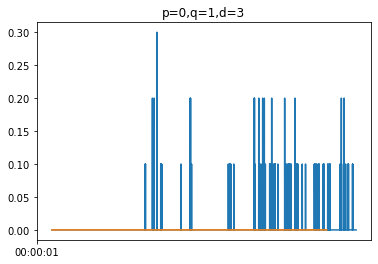

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13830D+00    |proj g|=  1.32902D+01

At iterate    5    f= -2.22477D+00    |proj g|=  4.09678D-01

At iterate   10    f= -2.22815D+00    |proj g|=  2.08781D+00

At iterate   15    f= -2.22893D+00    |proj g|=  1.21921D-02

At iterate   20    f= -2.22929D+00    |proj g|=  1.76813D-01

At iterate   25    f= -2.22941D+00    |proj g|=  1.31301D-01

At iterate   30    f= -2.22968D+00    |proj g|=  1.38289D-02

At iterate   35    f= -2.23016D+00    |proj g|=  3.40934D-01

At iterate   40    f= -2.23422D+00    |proj g|=  9.19324D-02

At iterate   45    f= -2.23771D+00    |proj g|=  2.82080D-01

At iterate   50    f= -2.23816D+00    |proj g|=  1.04963D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


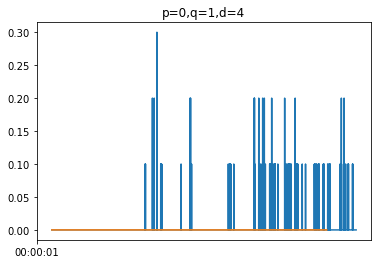

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.00403D-01    |proj g|=  3.73840D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   1.743D-04  -7.004D-01
  F = -0.70040825697088849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


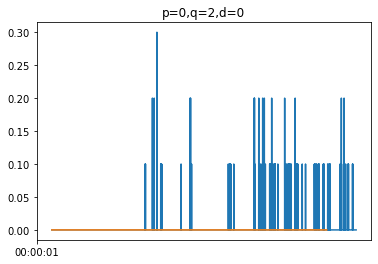

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mov

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.84411D-01    |proj g|=  1.54324D+01

At iterate    5    f= -7.94943D-01    |proj g|=  3.00243D+00

At iterate   10    f= -1.60048D+00    |proj g|=  4.59665D+00

At iterate   15    f= -1.73848D+00    |proj g|=  3.77317D-01

At iterate   20    f= -1.75386D+00    |proj g|=  3.13762D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     39      1     0     0   8.231D-02  -1.755D+00
  F =  -

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


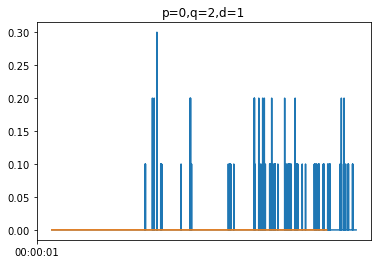

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28618D+00    |proj g|=  2.27340D+00

At iterate    5    f= -1.96983D+00    |proj g|=  3.05405D-01

At iterate   10    f= -1.99237D+00    |proj g|=  9.44743D-01

At iterate   15    f= -2.10231D+00    |proj g|=  4.88772D+00

At iterate   20    f= -2.13545D+00    |proj g|=  5.82757D+00

At iterate   25    f= -2.14804D+00    |proj g|=  8.22173D-02

At iterate   30    f= -2.15131D+00    |proj g|=  1.72722D+00

At iterate   35    f= -2.19527D+00    |proj g|=  1.01470D+00

At iterate   40    f= -2.19954D+00    |proj g|=  5.01645D-01

At iterate   45    f= -2.19968D+00    |proj g|=  2.21945D-01


/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.19988D+00    |proj g|=  1.10135D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      1     0     0   1.101D-01  -2.200D+00
  F =  -2.1998780262017359     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


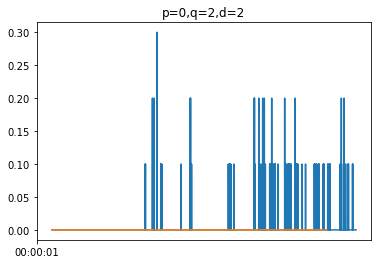

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mov

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47804D-01    |proj g|=  2.90192D+01

At iterate    5    f= -8.61235D-01    |proj g|=  1.38582D+00

At iterate   10    f= -1.90628D+00    |proj g|=  4.42745D+00

At iterate   15    f= -2.05592D+00    |proj g|=  3.68339D-01

At iterate   20    f= -2.06010D+00    |proj g|=  2.12486D+00

At iterate   25    f= -2.11547D+00    |proj g|=  1.89075D+00

At iterate   30    f= -2.15538D+00    |proj g|=  1.56169D-01

At iterate   35    f= -2.17619D+00    |proj g|=  4.42815D-02

At iterate   40    f= -2.17887D+00    |proj g|=  1.67117D+00
  ys=-2.269E-07  -gs= 4.830E-08 BFGS update SKIPPED

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

At iterate   45    f= -2.17941D+00    |proj g|=  9.28811D-02

At iterate   50    f= -2.17981D+00   

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


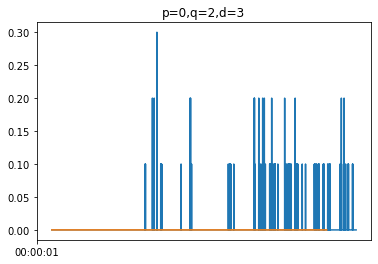

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mov

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42553D-01    |proj g|=  2.93136D+01

At iterate    5    f= -8.26556D-01    |proj g|=  1.00715D+00

At iterate   10    f= -1.91408D+00    |proj g|=  4.51443D+00

At iterate   15    f= -2.07974D+00    |proj g|=  2.67695D-01

At iterate   20    f= -2.09863D+00    |proj g|=  1.07942D+00

At iterate   25    f= -2.14198D+00    |proj g|=  5.48041D-01

At iterate   30    f= -2.17119D+00    |proj g|=  4.98751D-01

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

At iterate   35    f= -2.17939D+00    |proj g|=  3.74882D-02

At iterate   40    f= -2.18080D+00    |proj g|=  1.21618D-01

At iterate   45    f= -2.18086D+00    |proj g|=  1.55249D-01

At iterate   50    f= -2.18088D+00    |proj g|=  1.48953D-02

           * * *

Tit   = t

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


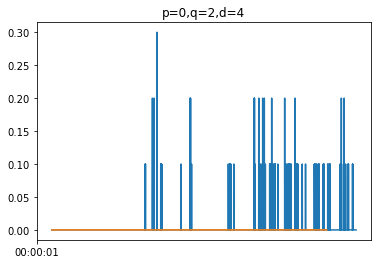

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87687D-01    |proj g|=  1.42479D+00

At iterate    5    f=  3.53148D-01    |proj g|=  3.96085D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      9      1     0     0   3.961D-06   3.531D-01
  F =  0.35314815956474349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


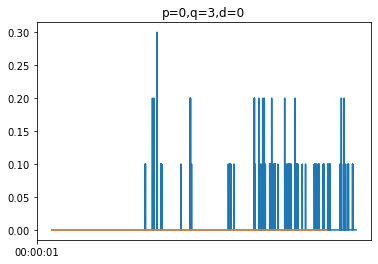

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mov

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55702D-01    |proj g|=  9.27721D-01

At iterate    5    f= -5.37591D-01    |proj g|=  2.10782D-01

At iterate   10    f= -7.91589D-01    |proj g|=  4.16061D-01

At iterate   15    f= -8.26575D-01    |proj g|=  4.87741D-02

At iterate   20    f= -8.29914D-01    |proj g|=  4.64390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     55      1     0     0   1.129D-01  -8.302D-01
  F = -0

/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


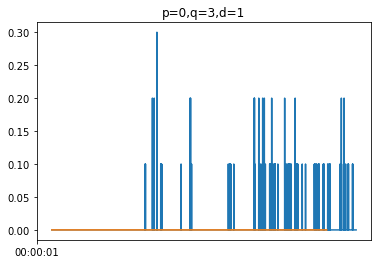

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.67649D-01    |proj g|=  4.61573D+00

At iterate    5    f= -1.17154D+00    |proj g|=  2.98738D-01

At iterate   10    f= -1.29772D+00    |proj g|=  5.77724D+00

At iterate   15    f= -1.38805D+00    |proj g|=  9.44498D-02

At iterate   20    f= -1.47987D+00    |proj g|=  2.94812D+00
  ys=-1.284E+06  -gs= 9.909E-01 BFGS update SKIPPED

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

    

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


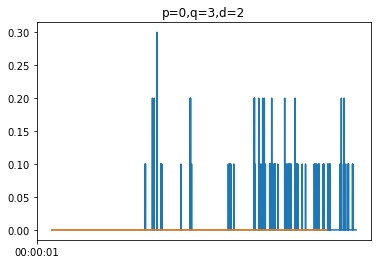

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mov

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17663D-01    |proj g|=  8.38366D+00

At iterate    5    f= -4.43832D-01    |proj g|=  5.75903D+00

At iterate   10    f= -7.97584D-01    |proj g|=  4.90245D-01

At iterate   15    f= -1.32990D+00    |proj g|=  9.79361D+00

At iterate   20    f= -1.44304D+00    |proj g|=  2.03169D-01

At iterate   25    f= -1.59873D+00    |proj g|=  1.66808D+00

At iterate   30    f= -1.75513D+00    |proj g|=  1.16360D+01

At iterate   35    f= -1.80087D+00    |proj g|=  1.02404D+00

At iterate   40    f= -1.81467D+00    |proj g|=  1.09683D+00
  ys=-3.130E-02  -gs= 1.066E-02 BFGS update SKIPPED

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

At iterate   45    f= -1.81491D+00    |proj g|=  6.27024D-02

 Bad direction in the line search;
  

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_4757/3055876277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)


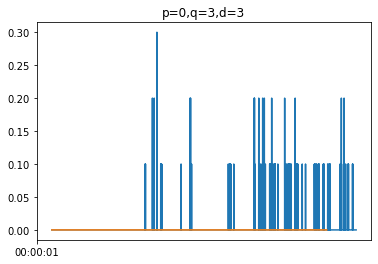

/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal mov

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56068D-01    |proj g|=  6.75418D+00

At iterate    5    f= -6.94801D-01    |proj g|=  2.30127D+00

At iterate   10    f= -1.30254D+00    |proj g|=  1.65456D+00

At iterate   15    f= -1.39829D+00    |proj g|=  1.21508D+00

At iterate   20    f= -1.62754D+00    |proj g|=  1.13579D+00

At iterate   25    f= -1.66650D+00    |proj g|=  3.17798D-01

At iterate   30    f= -1.76466D+00    |proj g|=  2.53385D+00

At iterate   35    f= -1.78581D+00    |proj g|=  1.79877D+00
  ys=-2.502E-11  -gs= 5.879E-11 BFGS update SKIPPED

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

At iterate   40    f= -1.78661D+00    |proj g|=  4.55980D-01

At iterate   45    f= -1.80332D+00    |proj g|=  2.66416D+00


/home/fragdata/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.80936D+00    |proj g|=  8.28224D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    104      2     1     0   8.282D-02  -1.809D+00
  F =  -1.8093583120041807     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
plt.figure(figsize=(10,8))
for p in range(5):
    for q in range(5):
        for d in range(5):
            model=sm.tsa.statespace.SARIMAX(df_lille.valeur,order=(p, q, d),seasonal_order=(p,q,d,12))
            results=model.fit()

            df_lille['forecast']=results.predict(start=0,end=5000,dynamic=True)
            plt.title(f'p={p},q={q},d={d}')
            plt.plot(df_lille[['valeur','forecast']])
            plt.show()